<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulated-images-generation" data-toc-modified-id="Simulated-images-generation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulated images generation</a></span><ul class="toc-item"><li><span><a href="#Other-single-purpose-snippets" data-toc-modified-id="Other-single-purpose-snippets-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Other single-purpose snippets</a></span></li></ul></li><li><span><a href="#Compiling-and-training-the-network" data-toc-modified-id="Compiling-and-training-the-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compiling and training the network</a></span></li><li><span><a href="#Classification-of-simulated-images" data-toc-modified-id="Classification-of-simulated-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification of simulated images</a></span></li><li><span><a href="#Classification-of-experimental-images" data-toc-modified-id="Classification-of-experimental-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification of experimental images</a></span><ul class="toc-item"><li><span><a href="#Training-with-noiseless-simulated-images,-testing-with-experimental-ones" data-toc-modified-id="Training-with-noiseless-simulated-images,-testing-with-experimental-ones-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training with noiseless simulated images, testing with experimental ones</a></span></li><li><span><a href="#Training-with-noisy-simulated-images,-testing-with-experimental-ones" data-toc-modified-id="Training-with-noisy-simulated-images,-testing-with-experimental-ones-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training with noisy simulated images, testing with experimental ones</a></span></li></ul></li></ul></div>

In [201]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.special
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

import keras
import keras.preprocessing.image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if './src' not in sys.path:
    sys.path.append('./src')
import src.vector_vortex_beams as VVB
import utils
from src.utils import abs2, borderless_imshow_save, imshow_intensities

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Going from scratch

Import images from file. The data is automatically randomised and coupled with labels by `keras`.
Moreover, the images are

1. Resized to $128\times 128\times 3$
2. Randomly zoomed in or out by some amount.
3. Put into batches of size $32$

Let us show some of these images for starters:

Found 6057 images belonging to 15 classes.
Shape of a batch of loaded images: (32, 128, 128, 3)


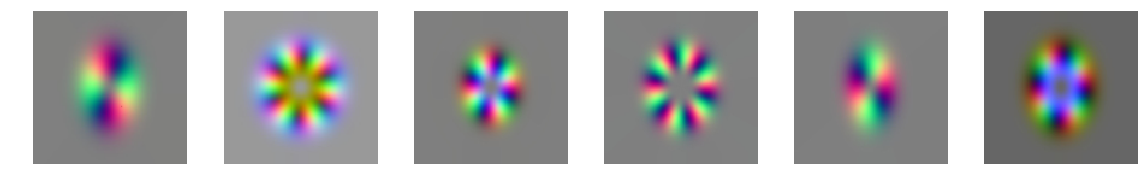

In [54]:
import keras
import keras.preprocessing.image
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, zoom_range=[0.8, 1.2])
training_set = train_datagen.flow_from_directory(
    './data/simulated 15 classes/training_set_balls_red',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)

batch_of_images = training_set.next()[0]
print('Shape of a batch of loaded images: {}'.format(batch_of_images.shape))
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))
for ax, image in zip(axs, batch_of_images[:len(axs)]):
    utils.plot_stokes_probs_as_rgb(stokes_probs=image, ax=ax);
plt.tight_layout()

# Simulated images generation

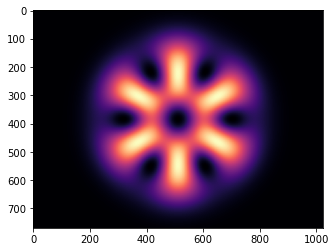

In [35]:
# Camera resolution
camera_width = 1024
camera_height = 768
# X and Y contain the coordinates of the pixels onto which the LG modes will be evaluated
Y, X = np.meshgrid(
    np.linspace(-camera_height / 2, camera_height / 2, num=camera_height + 1),
    np.linspace(-camera_width / 2, camera_width / 2, num=camera_width + 1),
    indexing='ij'
)
w0=150


# probs = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=[-5, 1], w0=w0, polarization_state=[1, 1] / np.sqrt(2))[1, :, :]

amps = VVB.LaguerreGauss(x=X, y=Y, p=0, m=-5, w0=w0) + VVB.LaguerreGauss(x=X, y=Y, p=0, m=1, w0=w0)
intensities = np.abs(amps)**2
plt.imshow(intensities, interpolation='nearest', cmap='magma');

The following code is used to generate a dataset of images of the type used to train and classify the CNN.
The dataset consists of a single directory containing a number of subdirectory. Each subdirectory corresponds to a pair of OAM quantum numbers $(m_1, m_2)$, and contains Stokes parameters of VVBs of the form $|H,m_1\rangle+e^{i\phi}|V,m_2\rangle$ for various values of the phase $\phi$.

In [90]:
target_dir = './data/simulated15classes'
if os.path.isdir(target_dir):
    raise ValueError('The dataset directory already exists!')

classes = [(-1, 1), (-3, 3), (-5, 5),
           (-5, -3), (-5, -1), (-5, 1), (-5, 3),
           (-3, -1), (-3, 1), (-3, 5),
           (-1, 3), (-1, 5), (1, 3), (1, 5), (3, 5)]
classes_names = []
for class_ in classes:
    classes_names.append('{:+}{:+}'.format(class_[0], class_[1]))
# create parent dir
os.mkdir(target_dir)
# create a subdir for each class
for class_, class_name in zip(classes, classes_names):
    # build path and create directory in it
    subdir_name = os.path.join(target_dir, class_name)
    os.mkdir(subdir_name)
    # we use 500 phases between 0 and 2pi
    phases = np.linspace(0, 2 * np.pi, 500)
    # for each phase, we generate the correpsonding polarisation vector state, and then the corresponding VVB
    for idx, phase in enumerate(phases):
        pol_state = [1, np.exp(1j * phase)] / np.sqrt(2)
        image_data = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=class_, w0=w0, polarization_state=pol_state)
        image_data[[0, 1, 2]] = image_data[[1, 2, 0]]  # this is to match with the convention used to generate exp data
        image_data = np.transpose(image_data, [1, 2, 0])
        image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
        # save generate image to file (this goes in the appropriate subdirectory)
        output_file_name = os.path.join(subdir_name, '{:03}.png'.format(idx))
        utils.borderless_imshow_save(image_data, outputname=output_file_name, dpi=200)

Same as above but generating noisy images

In [100]:
target_dir = './data/simulated15classes_noise0.1'
noise_level = 0.1
if os.path.isdir(target_dir):
    raise ValueError('The dataset directory already exists!')

classes = [(-1, 1), (-3, 3), (-5, 5),
           (-5, -3), (-5, -1), (-5, 1), (-5, 3),
           (-3, -1), (-3, 1), (-3, 5),
           (-1, 3), (-1, 5), (1, 3), (1, 5), (3, 5)]
classes_names = []
for class_ in classes:
    classes_names.append('{:+}{:+}'.format(class_[0], class_[1]))
# create parent dir
os.mkdir(target_dir)
# create a subdir for each class
for class_, class_name in progressbar.progressbar(zip(classes, classes_names)):
    subdir_name = os.path.join(target_dir, class_name)
    os.mkdir(subdir_name)
    # make data to fill subdir
    phases = np.linspace(0, 2 * np.pi, 500)
    for idx, phase in enumerate(phases):
        pol_state = [1, np.exp(1j * phase)] / np.sqrt(2)
        image_data = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=class_, w0=w0, polarization_state=pol_state)
        image_data[[0, 1, 2]] = image_data[[1, 2, 0]]  # this is to match with the convention used to generate exp data
        image_data = utils.add_noise_to_array(image_data, noise_level=noise_level)
        image_data = np.transpose(image_data, [1, 2, 0])
        image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
        utils.borderless_imshow_save(image_data, outputname=os.path.join(subdir_name, '{:03}.png'.format(idx)), dpi=200)

| |                                     #            | 14 Elapsed Time: 1:25:33


# Train and test CNNs on simulated VVBs

In [536]:
!du -h saved_CNN_models/*

30M	saved_CNN_models/1convlayer_5x5pools.h5
187M	saved_CNN_models/1convlayer.h5
172K	saved_CNN_models/2convs_5x5pools_32dense.h5
464K	saved_CNN_models/4convlayers_5x5firstmaxpool.h5


In [539]:
foo = Sequential()
foo.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3)))
foo.add(MaxPooling2D(pool_size = (10, 10)))
foo.add(Conv2D(16, (3, 3), activation='relu'))
foo.add(MaxPooling2D(pool_size=(5, 5)))
# foo.add(Conv2D(16, (3, 3), activation='relu'))
# foo.add(MaxPooling2D(pool_size=(3, 3)))
# foo.add(Conv2D(32, (3, 3), activation='relu'))
foo.add(Flatten())
# Fully connected layer
foo.add(Dense(units=32, activation='relu'))
foo.add(Dense(units=num_classes, activation='softmax'))
foo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_42 (Dense)             (None, 15)                495       
Total para

In [540]:
# Initialising the CNN
classifier = Sequential()
# classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (5, 5)))
# classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size=(2, 2)))
# classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size=(2, 2)))
# classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (10, 10)))
classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(5, 5)))
# classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(Flatten())
# Fully connected layer
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))

# Compile CNN for classification problem
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, zoom_range=[0.8, 1.2])
training_set = train_datagen.flow_from_directory(
    './data/simulated 15 classes/training_set_balls_red',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_set = test_datagen.flow_from_directory(
    './data/simulated 15 classes/test_set_balls_red',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)
h = classifier.fit_generator(
    training_set, steps_per_epoch=200,  # 8000
    epochs=3, validation_data=test_set, validation_steps=100  # 2000 steps
)

# classifier.save('./saved_CNN_models/1convlayer.h5')

Found 6056 images belonging to 15 classes.
Found 4215 images belonging to 15 classes.
Epoch 1/3
200/200 [==============================] - 133s 665ms/step - loss: 1.9900 - acc: 0.3739 - val_loss: 0.7905 - val_acc: 0.8478
Epoch 2/3
200/200 [==============================] - 132s 660ms/step - loss: 0.4406 - acc: 0.9158 - val_loss: 0.1621 - val_acc: 0.9987
Epoch 3/3
200/200 [==============================] - 131s 653ms/step - loss: 0.1548 - acc: 0.9780 - val_loss: 0.0639 - val_acc: 0.9994


Test trained CNN feeding it directly with a manually resized image from the dataset:

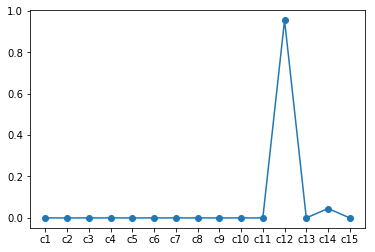

In [339]:
import PIL
image_path = './data/simulated 15 classes/training_set_balls_red/c12/c12_100.png'
with PIL.Image.open(image_path) as image:
    # this seems to be how keras resizes images as well, as per
    # https://github.com/keras-team/keras-preprocessing/blob/f80d4a1952804c769d7f37601001750a19015028/keras_preprocessing/image/utils.py#L138
    image = image.resize(size=(128, 128))
    image_data = np.asarray(image) / 255
    ans = classifier.predict(np.asarray([image_data]))
    plt.plot(['c{}'.format(idx + 1) for idx in range(15)], ans[0], 'o-')

***Study accuracy for class***. Manually load all images and test the trained model on them.

Test a trained model on the test set, and print truth table and (some of the) mispredicted images. Note how the mispredicted images are all images that were 

In [543]:
def _():
    # load trained model
    classifier = keras.models.load_model('./saved_CNN_models/2convs_10and5pools_32dense.h5')
    print('Loaded the model. Loading images...')
    # set up path to use to test the model
    dataset_path = './data/simulated 15 classes/test_set_balls_red'
    # iterate through all the images and load them into memory
    all_images_paths = glob.glob(os.path.join(dataset_path, '*/*.png'))
    num_images = len(all_images_paths)
    all_images = np.zeros(shape=(num_images, 128, 128, 3), dtype=np.float)
    true_labels = np.ones(num_images, dtype=np.int) * (-1)
    # for idx, image_path in tqdm.tqdm(list(enumerate(all_images_paths[:20]))):
    for idx, image_path in tqdm.tqdm(list(enumerate(all_images_paths)), position=0, leave=True):
        # extract label index for dir name, and send c01 to 0 etc.
        true_labels[idx] = int(os.path.split(os.path.split(image_path)[0])[1][1:]) - 1
        # load image
        all_images[idx] = np.asarray(PIL.Image.open(image_path).resize((128, 128))) / 255
    # make predictions
    predictions = classifier.predict_classes(all_images)
    # rearrange data to make table of accuracies. We iterate through each "true label",
    # fetch the corresponding indices, and see how each of these images was classified.
    # Show mispredicted images, if any
    mispredicted_indices = np.argwhere(predictions != true_labels).flatten()
    num_bad_images = min(len(mispredicted_indices), 5)
    print('Number of mispredicted images: {}'.format(num_bad_images))
    if num_bad_images > 0:
        fig, axs = plt.subplots(1, num_bad_images, figsize=(8, 12))
        for idx, bad_idx in enumerate(mispredicted_indices[:5]):
            img = all_images[bad_idx]
            # we need to add this exception for the case of a single bad image because in this case
            # axs is not a list of axes anymore, but a single axis, and thus does not
            # support indexing
            if num_bad_images > 1:
                ax = axs[idx]
            else:
                ax = axs
            ax.imshow(img); ax.axis('off')
            ax.set_title(os.path.split(all_images_paths[bad_idx])[1])
        # extract paths of mispredicted images
        bad_paths_to_print = []
        for bad_idx in mispredicted_indices:
            bad_paths_to_print.append(os.path.split(all_images_paths[bad_idx])[1])
        print('Mispredicted images: {}'.format(bad_paths_to_print))
        # print truth table (ONLY IF there are mispredicted images)
        accuracies = []
        for label in set(true_labels):
            correct_indices = np.argwhere(true_labels == label).flatten()
            counts = np.bincount(predictions[correct_indices]).astype(np.float)
            counts = np.append(counts, np.zeros(15 - counts.shape[0]))
            counts /= correct_indices.shape[0]
            accuracies.append(counts)
        accuracies = np.array(accuracies)
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        sns.heatmap(accuracies, annot=True, cbar=False, square=True, ax=ax)
_()

  0%|          | 9/4200 [00:00<00:46, 89.75it/s]

Loaded the model. Loading images...


100%|██████████| 4200/4200 [00:52<00:00, 80.76it/s] 


Number of mispredicted images: 0


# Train on simulated, test on experimental VVBs

We try here to train a CNN on exclusively simulated images (both noisy and noiseless) and have the network generalise to experimental ones.

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, zoom_range=[0.8, 1.2])
training_set = train_datagen.flow_from_directory(
    './data/simulated 15 classes/training_set_balls_red',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_set = test_datagen.flow_from_directory(
    './data/simulated 15 classes/test_set_balls_red',
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)
h = classifier.fit_generator(
    training_set, steps_per_epoch=200,  # 8000
    epochs=3, validation_data=test_set, validation_steps=100  # 2000 steps
)

In [544]:
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (10, 10)))
classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(5, 5)))
classifier.add(Flatten())
# Fully connected layer
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simulated15classes_dataset_dir = './data/simulated15classes'
experimental_dataset_dir = './data/experimental/distinct_classes'

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                             zoom_range=[0.8, 1.2])
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

training_set_simulated15classes = train_datagen.flow_from_directory(
    simulated15classes_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)
test_set_exp15classes = test_datagen.flow_from_directory(
    experimental_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical'
)

h = classifier.fit_generator(
    training_set_simulated15classes, validation_data=test_set_exp15classes,
    steps_per_epoch=200, epochs=3, validation_steps=100)

Found 7500 images belonging to 15 classes.
Found 1968 images belonging to 15 classes.
Epoch 1/3
200/200 [==============================] - 276s 1s/step - loss: 2.2491 - acc: 0.2961 - val_loss: 2.6220 - val_acc: 0.0870
Epoch 2/3
200/200 [==============================] - 107s 535ms/step - loss: 0.6983 - acc: 0.8552 - val_loss: 4.1582 - val_acc: 0.0919
Epoch 3/3
200/200 [==============================] - 103s 514ms/step - loss: 0.2481 - acc: 0.9546 - val_loss: 5.3016 - val_acc: 0.1184


The `2convs_10and5pools_32dense` architecture, trained on only simulated noisy images, achieves ~0.2 accuracy on experimental images. That's not too bad considering the roughness of the model.

In [548]:
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (10, 10)))
classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(5, 5)))
classifier.add(Flatten())
# Fully connected layer
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simulated15classesnoisy_dataset_dir = './data/simulated15classes_noise0.1'
exp15classes_dataset_dir = './data/experimental/distinct_classes'

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255, # shear_range=0.2,
                                   zoom_range=[0.8, 1.2])
test_datagen = ImageDataGenerator(rescale=1/255)

dataset_sim15classesnoisy = train_datagen.flow_from_directory(
    simulated15classesnoisy_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')
dataset_exp15classes = test_datagen.flow_from_directory(
    exp15classes_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')

h = classifier.fit_generator(
    dataset_sim15classesnoisy, validation_data=dataset_exp15classes,
    steps_per_epoch=200, epochs=3, validation_steps=100)

Found 7500 images belonging to 15 classes.
Found 1968 images belonging to 15 classes.
Epoch 1/3
200/200 [==============================] - 236s 1s/step - loss: 2.3745 - acc: 0.2089 - val_loss: 2.4147 - val_acc: 0.2726
Epoch 2/3
200/200 [==============================] - 125s 623ms/step - loss: 1.0681 - acc: 0.6176 - val_loss: 4.2370 - val_acc: 0.2633
Epoch 3/3
200/200 [==============================] - 114s 569ms/step - loss: 0.6608 - acc: 0.7542 - val_loss: 4.9966 - val_acc: 0.2211


Like above but allowing for more distortion of the images via zooming, shearing, and translations. This gives somewhat better results.

Found 7500 images belonging to 15 classes.


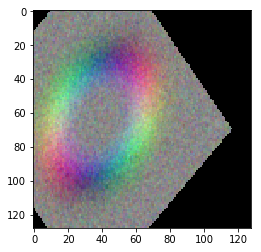

In [1236]:
plt.imshow(
    ImageDataGenerator(
        shear_range=0.4, rotation_range=90, rescale=1/255,
        zoom_range=[0.7, 1.3], brightness_range=[0.5, 2],
        width_shift_range=0.3, height_shift_range=0.3, fill_mode='constant'
    ).flow_from_directory(simulated15classesnoisy_dataset_dir, target_size=(128, 128)).next()[0][0]
)

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(3, 3)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simulated15classesnoisy_dataset_dir = './data/simulated15classes_noise0.1'
exp15classes_dataset_dir = './data/experimental/15classes'

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.4, rotation_range=90, rescale=1/255,
    zoom_range=[0.7, 1.3], brightness_range=[0.5, 2],
    width_shift_range=0.3, height_shift_range=0.3, fill_mode='constant')
test_datagen = ImageDataGenerator(rescale=1/255)

dataset_sim15classesnoisy = train_datagen.flow_from_directory(
    simulated15classesnoisy_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')
dataset_exp15classes = test_datagen.flow_from_directory(
    exp15classes_dataset_dir,
    target_size=(128, 128), batch_size=32, class_mode='categorical')

h = classifier.fit_generator(
    dataset_sim15classesnoisy, validation_data=dataset_exp15classes,
    steps_per_epoch=200, epochs=200)

Found 7500 images belonging to 15 classes.
Found 1971 images belonging to 15 classes.
Epoch 1/200
199/200 [============================>.] - ETA: 0s - loss: 2.7099 - acc: 0.0669

Loaded the model. Loading images...
Found 1971 images belonging to 15 classes.


100%|██████████| 1968/1968 [00:23<00:00, 85.43it/s]


Found 1971 images belonging to 15 classes.
Number of mispredicted images: 1452
Some mispredicted images: ['./data/experimental/distinct_classes/+1+3/c13_ (1).jpeg'
 './data/experimental/distinct_classes/+1+3/c13_ (10).jpeg'
 './data/experimental/distinct_classes/+1+3/c13_ (100).jpeg'
 './data/experimental/distinct_classes/+1+3/c13_ (11).jpeg'
 './data/experimental/distinct_classes/+1+3/c13_ (12).jpeg']


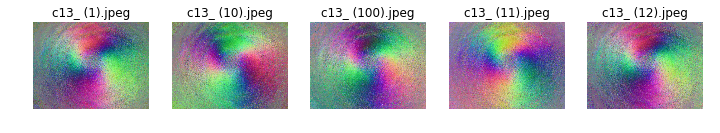

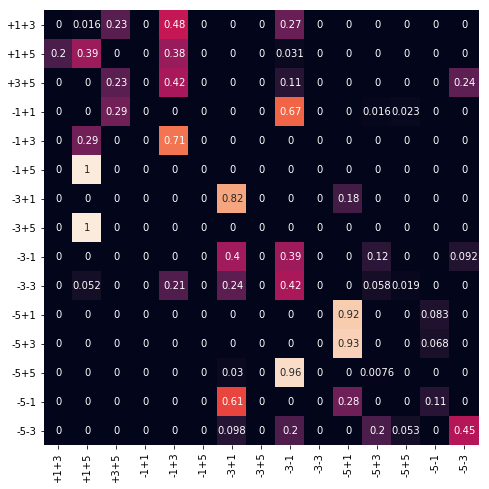

In [620]:
def _():
    # load trained model
    classifier = keras.models.load_model('./saved_CNN_models/test.h5')
    print('Loaded the model. Loading images...')
    dataset_path = './data/experimental/distinct_classes'
    all_images_paths = utils.find_all_images_in_dir(dataset_path)
    all_images, true_labels = utils.load_images_and_labels_from_dir(dataset_path)
    classes_to_indices_dict = utils.serialize_class_directories(dataset_path)
    predictions = classifier.predict_classes(all_images)
    # Show mispredicted images, if any, and truth table
    mispredicted_indices = np.argwhere(predictions != true_labels).flatten()
    print('Number of mispredicted images: {}'.format(len(mispredicted_indices)))
    num_bad_images = min(len(mispredicted_indices), 5)
    if num_bad_images > 0:
        some_mispredicted_imgs = all_images_paths[mispredicted_indices[:5]]
        utils.imshow_row_from_paths(plt_opts=dict(figsize=(12, 16)),
            paths=some_mispredicted_imgs,
            titles=utils.filenames_from_list_of_paths(some_mispredicted_imgs)
        )
        print('Some mispredicted images: {}'.format(some_mispredicted_imgs))
        utils.print_truth_table(true_labels, predictions, classes_to_indices_dict)
_()

# Train and test on experimental VVBs

In [637]:
!ls ./data/experimental

15classes	 26classes	  bloch_sphere_26classes_withAngles
15classes_split  26classes_split  other_distinct_classes


We need to split the experimental dataset to see how many experimental images are needed to accurately classify the rest.

In [944]:
utils.find_all_images_in_dir('./data/experimental/15classes').shape[0]

1968

In [ ]:
x_train, y_train, x_test, y_test = utils.split_dataset_into_train_and_test(
    original_path='./data/experimental/15classes',
    dim_train_set=20
)

 20%|██        | 3/15 [00:43<02:55, 14.61s/it]

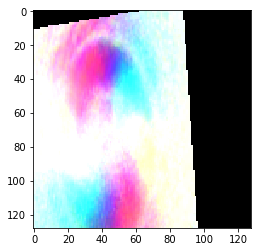

In [1206]:
foo = ImageDataGenerator(
        shear_range=0.2, rotation_range=90,
        zoom_range=[0.7, 1.3], brightness_range=[0.5, 2],
        fill_mode='constant',
        width_shift_range=0.3, height_shift_range=0.3, rescale=1/255
    ).flow(x=x_train, y=y_train, batch_size=32).next()[0][0]
plt.imshow(foo);

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (4, 4)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(3, 3)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=15, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# x_train.shape
h = classifier.fit_generator(
    ImageDataGenerator(
        shear_range=0.2, rotation_range=90, zoom_range=[0.7, 1.3],
        brightness_range=[0.5, 2], fill_mode='constant',
        width_shift_range=0.3, height_shift_range=0.3, rescale=1/255
    ).flow(x=x_train, y=y_train, batch_size=32),
    steps_per_epoch=200, epochs=100, validation_data=(x_test, y_test)
)

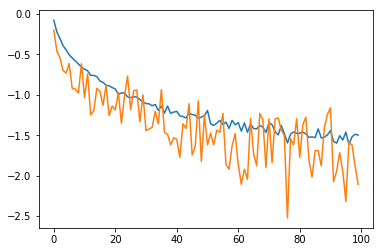

In [1184]:
plt.plot(np.log10(1 - np.asarray(h.history['acc'])))
plt.plot(np.log10(1 - np.asarray(h.history['val_acc'])));

In [1207]:
classifier.save('./saved_CNN_models/3convs_432pools_64dense_exp2expGreatAcc.h5')

In [1187]:
classifier.evaluate(x=x_train, y=y_train)

300/300 [==============================] - 1s 2ms/step


[0.004852904556323665, 1.0]

In [1188]:
classifier.evaluate(x=x_test, y=y_test)

1668/1668 [==============================] - 4s 2ms/step


[0.023006330522504084, 0.9922062350119905]

Let's have a look at the misclassified images:

In [1189]:
print(np.argwhere(classifier.predict_classes(x=x_train) != np.argmax(y_train, axis=1)).flatten())
print(np.argwhere(classifier.predict_classes(x=x_test) != np.argmax(y_test, axis=1)).flatten())

[]
[ 143  190  269  576  805  819 1350 1428 1502 1536 1628 1639 1644]


Is there a clear reason why 248 and 297 in the training set are misclassified? Looking at those images with some neighboring (correctly classified) ones doesn't seem to reveal any obvious reason.

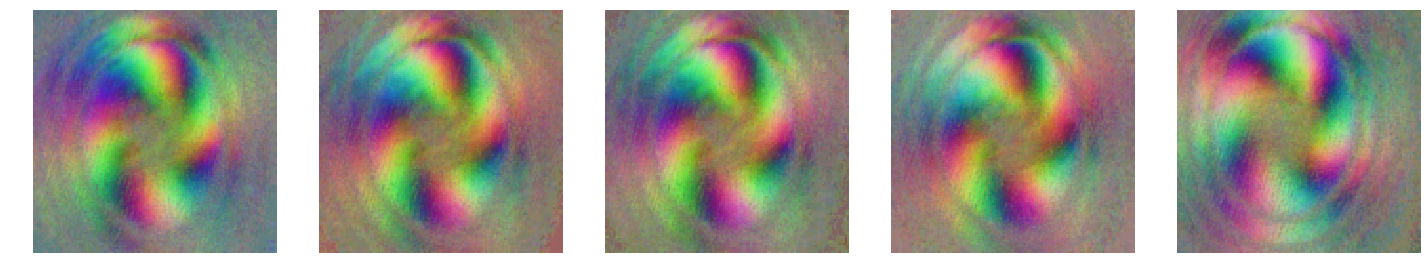

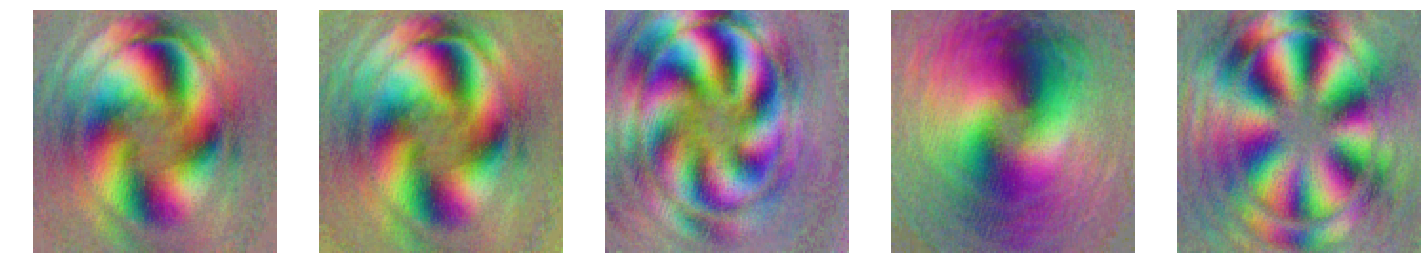

In [1197]:
_, axs = plt.subplots(1, 5, figsize=(20, 10))
[ax.imshow(img) for ax, img in zip(axs, x_test[140:145])];
[ax.axis('off') for ax in axs]; plt.tight_layout()

_, axs = plt.subplots(1, 5, figsize=(20, 10))
[ax.imshow(img) for ax, img in zip(axs, x_test[[143, 190, 269, 576, 805]])];
[ax.axis('off') for ax in axs]; plt.tight_layout()

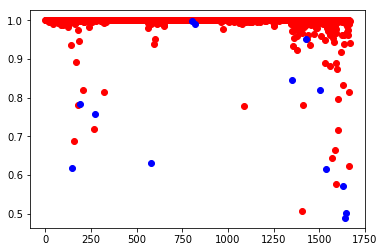

In [1195]:
def _():
    good_indices = np.argwhere(classifier.predict_classes(x_test) == np.argmax(y_test, axis=1)).flatten()
    bad_indices = np.argwhere(classifier.predict_classes(x_test) != np.argmax(y_test, axis=1)).flatten()
    _, ax = plt.subplots(1, 1)
    ax.plot(good_indices, np.max(classifier.predict(x_test[good_indices]), axis=1), 'ro')
    ax.plot(bad_indices, np.max(classifier.predict(x_test[bad_indices]), axis=1), 'bo')
_()

Found 1971 images belonging to 15 classes.


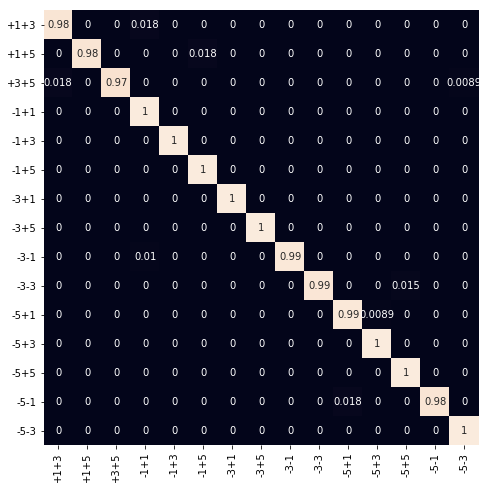

In [1196]:
utils.print_truth_table(np.argmax(y_test, axis=1), classifier.predict_classes(x_test),
                        utils.serialize_class_directories('./data/experimental/15classes'))